In [23]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
# uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [0]:
import geopy

In [0]:
data=requests.get("https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai")

In [0]:
df=pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai')

In [0]:
df_suburbs_chennai=df[1]

In [0]:
suburbs_list=df_suburbs_chennai.iloc[0][0].split(" ")

In [0]:
chennai_suburbs_df=pd.DataFrame(suburbs_list,columns=['cities'])

In [0]:
import time 
geolocator = Nominatim(user_agent="IBM project")
def lat_long_getter(city):
  time.sleep(1)
  location = geolocator.geocode(city)
  if location is not None:
    return (location.latitude, location.longitude)

In [0]:
#checking lat long
lat_long_list=[lat_long_getter(x) for x in suburbs_list]

In [0]:
chennai_suburbs_df['cities'].apply(lat_long_getter)

In [79]:
len(lat_long_list)

201

In [0]:
chennai_cities_df=pd.concat([chennai_suburbs_df,pd.DataFrame(lat_long_list,columns=['lat','long'])],axis=1)

In [104]:
chennai_cities_df.head(5)

,cities,lat,long
0,Adyar,13.006450,80.257779
1,Adambakkam,12.982221,80.209121
2,Alapakkam,13.049901,80.165435
3,Alandur,13.002822,80.171919
4,Alwarpet,13.033860,80.254549


In [100]:
chennai_cities_df.shape

(201, 3)

In [0]:
chennai_cities_df.dropna(how='any',inplace=True)

In [103]:
chennai_cities_df.shape

(188, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82ed8c07b8>,
      dtype=object)

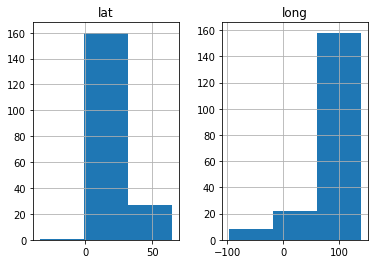

In [108]:
chennai_cities_df.hist(bins=3)

In [110]:
chennai_cities_df.describe()

,lat,long
count,188.000000,188.000000
mean,18.090299,64.710376
std,12.749641,38.823500
min,-33.922955,-96.886392
25%,12.977265,77.843412
50%,13.072082,80.170070
75%,13.343911,80.235861
max,64.984182,139.638865


In [112]:
chennai_cities_df[(chennai_cities_df['lat'].between(12.977265,13.343911)) &
                  (chennai_cities_df['long'].between(77.843412,80.235861))].shape

(58, 3)

In [0]:
Q1 = chennai_cities_df.quantile(0.25)
Q3 = chennai_cities_df.quantile(0.75)
IQR = Q3 - Q1

outlier_removed_df = chennai_cities_df[~((chennai_cities_df < (Q1 - 1.5 * IQR)) |(chennai_cities_df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [119]:
outlier_removed_df.shape

(136, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82ee106320>,
      dtype=object)

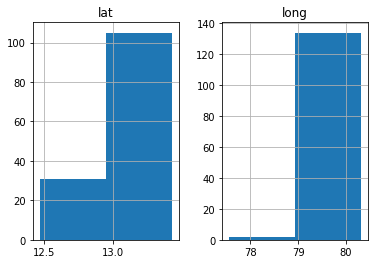

In [122]:
outlier_removed_df.hist(bins=2
                        )

In [124]:
outlier_removed_df.columns

Index(['cities', 'lat', 'long'], dtype='object')

In [0]:
radius = 2000
LIMIT = 100
CLIENT_ID="OEKKGI1XLJWV3KHMVSN4CRIJD0BJ5SSA2J5WEMMKTDOTRUUR"
CLIENT_SECRET="Q5JTR2RYCYT4OE1CVFR1REBLKFKHRK2ZOYTFGHDALXNNTQGD"
VERSION=20200201
venues = []

for lat, long,city in zip(outlier_removed_df['lat'], outlier_removed_df['long'],
                    outlier_removed_df['cities']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    print(url)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            city,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [0]:
venues

In [0]:
venues_df = pd.DataFrame(venues)


In [0]:
venues_df.columns=['city','lat','lon','name','loc_lat','loc_long','type']

In [0]:
venues_df.type.unique()

In [138]:
venues_df.shape

(3839, 7)

In [0]:
venues_df.type.unique()

filtering for station and restaruant and market

In [0]:
venues_df_filter=venues_df[venues_df['type'].str.contains('Station|Restaurant|Market')]

In [145]:
venues_df_filter.shape ,venues_df.shape

((1580, 7), (3839, 7))

In [0]:
# one hot encoding
venues_df_filter_onehot = pd.get_dummies(venues_df_filter[['type']], prefix="", prefix_sep="")

venues_df_one_hot_df=pd.concat([venues_df_filter[:-1],venues_df_filter_onehot],axis=1)



In [0]:
venues_df_group= venues_df_one_hot_df.groupby('city').mean().reset_index()

In [154]:
venues_df_group.shape

(120, 51)

In [157]:
# set number of clusters
kclusters = 3

kl_clustering = venues_df_group.drop(["city"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [160]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 0, 2], dtype=int32)

In [0]:
venues_df_group['cluster']=kmeans.labels_

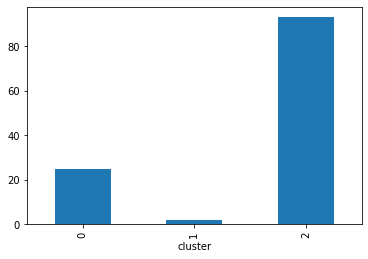

In [168]:
venues_df_group.groupby('cluster').count()['city'].plot(kind='bar')

In [171]:
venues_df_group[venues_df_group['cluster']==1]

,city,lat,lon,loc_lat,loc_long,Afghan Restaurant,African Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Bengali Restaurant,Burmese Restaurant,Bus Station,Chettinad Restaurant,Chinese Restaurant,Comfort Food Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Gas Station,Halal Restaurant,Hyderabadi Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Light Rail Station,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Punjabi Restaurant,Rajasthani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Thai Restaurant,Theme Restaurant,Train Station,Vegetarian / Vegan Restaurant,cluster
86,Shenoy,12.930837,77.584122,12.926998,77.583580,0.0,0.0,0.0,0.022222,0.022222,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.088889,0.0,0.0,0.0,0.0,0.0,0.511111,0.044444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022222,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.066667,0.0,0.066667,0.0,0.0,0.0,0.0,1
103,Tolgate,12.978422,77.548794,12.980337,77.544139,0.0,0.0,0.0,0.000000,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.263158,0.0,0.0,0.0,0.0,0.0,0.578947,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.052632,0.0,0.000000,0.0,0.0,0.0,0.0,1
